In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

! pip install xlrd
! pip install openpyxl


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
presidential_data = pd.read_csv('data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)


In [3]:
# def calculate_political_scores(df, year=2020):
#     df = df[df['year'] <= year]
#     df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])]
#
#     df_filtered['vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100
#
#     df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()]
#
#     state_streaks = {}
#     for state in df_winner['state'].unique():
#         state_data = df_winner[df_winner['state'] == state].sort_values('year')
#         current_party = None
#         streak = 0
#         max_streak = 0
#         last_winner = None
#
#         for _, row in state_data.iterrows():
#             if row['party_simplified'] == current_party:
#                 streak += 1
#             else:
#                 current_party = row['party_simplified']
#                 streak = 1
#             max_streak = max(max_streak, streak)
#             last_winner = current_party
#
#         state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}
#
#     df_summary = df_winner.groupby('state').agg(
#         total_elections=('year', 'count'),
#         avg_vote_percent=('vote_percent', 'mean'),
#         last_winner=('party_simplified', 'last'),
#         last_vote_percent=('vote_percent', 'last')
#     ).reset_index()
#
#     df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
#     df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])
#
#     df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})
#
#     features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]
#
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     df_summary[['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)
#
#     df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
#                                  df_summary['avg_vote_score'] * 0.3 +
#                                  df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
#
#     df_summary['year'] = year
#
#     return df_summary[['state', 'year', 'final_score']]
#
# def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
#     df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
#                                .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))
#
#     df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)
#
#     return df_combined[['state', 'year', 'final_score_avg']]
#
# def calculate_scores_by_year(presidential_data, house_data, senate_data):
#     years = sorted(presidential_data['year'].unique())
#     all_scores = []
#
#     for year in years:
#         pres_results = calculate_political_scores(presidential_data, year)
#         house_results = calculate_political_scores(house_data, year)
#         sen_results = calculate_political_scores(senate_data, year)
#         final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
#         all_scores.append(final_political_score)
#
#     return pd.concat(all_scores).reset_index(drop=True)


In [4]:
def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']

    df_summary['year'] = year

    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

In [5]:
final_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)

In [6]:
final_scores_by_year

,state,year,final_score_avg
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


In [7]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


In [8]:
valid_states = set(final_scores_by_year["state"].unique())
state_emissions_data["State"] = state_emissions_data["State"].str.upper().str.strip()
state_emissions_data = state_emissions_data[state_emissions_data["State"].isin(valid_states)]

df_merged = final_scores_by_year.merge(
    state_emissions_data.melt(id_vars=["State"], var_name="year", value_name="emissions"),
    left_on=["state", "year"],
    right_on=["State", "year"],
    how="inner"
).drop(columns=["State"])

scaler = MinMaxScaler(feature_range=(-1, 1))
df_merged[["final_score_avg", "emissions"]] = scaler.fit_transform(df_merged[["final_score_avg", "emissions"]])

df_merged

,state,year,final_score_avg,emissions
0,ARIZONA,1976,-0.406619,-0.882642
1,CALIFORNIA,1976,0.972995,-0.034357
2,CONNECTICUT,1976,0.861127,-0.883736
3,DELAWARE,1976,0.300783,-0.965510
4,FLORIDA,1976,-0.649381,-0.610844
...,...,...,...,...
578,VIRGINIA,2020,-0.258970,-0.721536
579,WASHINGTON,2020,-0.015588,-0.810196
580,WEST VIRGINIA,2020,-0.283206,-0.784203
581,WISCONSIN,2020,-0.395393,-0.754376


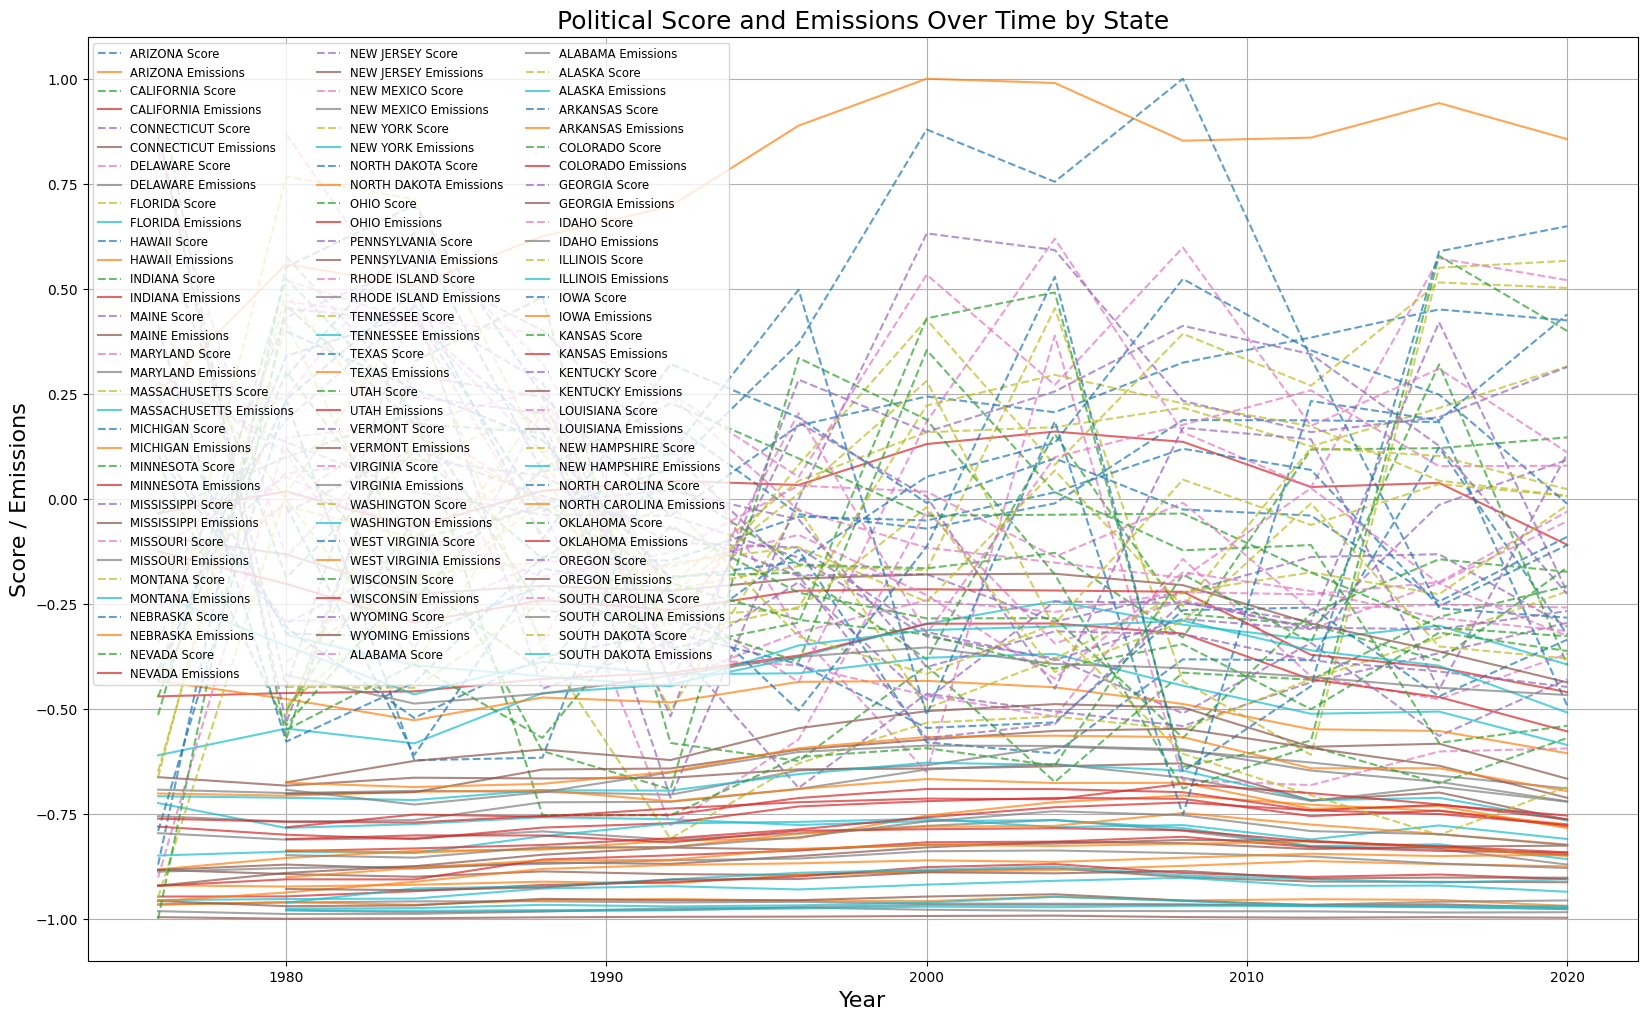

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))

states = df_merged["state"].unique()

for state in states:
    state_data = df_merged[df_merged["state"] == state]
    plt.plot(state_data["year"], state_data["final_score_avg"], label=f"{state} Score", linestyle="--", alpha=0.7)
    plt.plot(state_data["year"], state_data["emissions"], label=f"{state} Emissions", alpha=0.7)

plt.xlabel("Year", fontsize=16)
plt.ylabel("Score / Emissions", fontsize=16)
plt.title("Political Score and Emissions Over Time by State", fontsize=18)
plt.legend(loc="upper left", fontsize="small", ncol=3, frameon=True)
plt.grid(True)

plt.show()
